In [1]:
### If You do not have one of these packages, you can simply run: !pip install <package>

# You may also find this video helpful for permanent installations (basically installs folder to your drive)
# >> https://www.youtube.com/watch?v=ErwLcnvhW4A&t=473s

# You may also find this paper helpful for some intro information / description of optimizer algorithms
# >> https://arxiv.org/pdf/1803.08823

import torch
from fastai.tabular.all import *
from tqdm import tqdm

from torch.utils.data import DataLoader
from torch.utils.data import Dataset

In [2]:
import sympy as sym
from scipy.integrate import quad
from scipy.integrate import cumulative_trapezoid

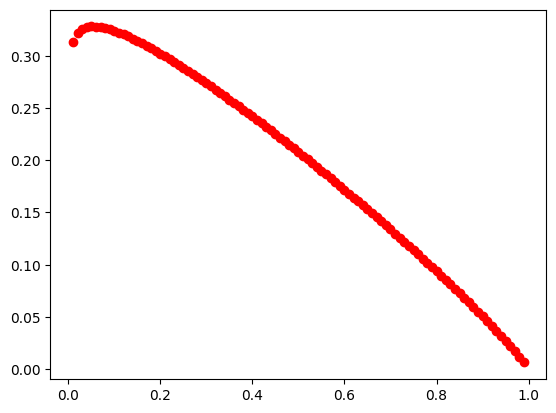

In [ ]:
### Toy Model Parton Distribution Function

#x = torch.arange(1,100).float()/100. #LINEAR
x = torch.logspace(-2, 0, steps = 100) #LOGARITHMIC

def h(x, params):

  N,a,b = params

  return N*x**a*(1-x)**b

def show(preds, ax=None):
    if ax is None:
        ax = plt.subplots()[1]
    # ax.scatter(time, signal)
    ax.scatter(x, to_np(preds), color="red")
    plt.show()

sig_params = torch.abs(torch.randn(3)).requires_grad_()
# sig_params
signal = h(x, sig_params)
show(signal)

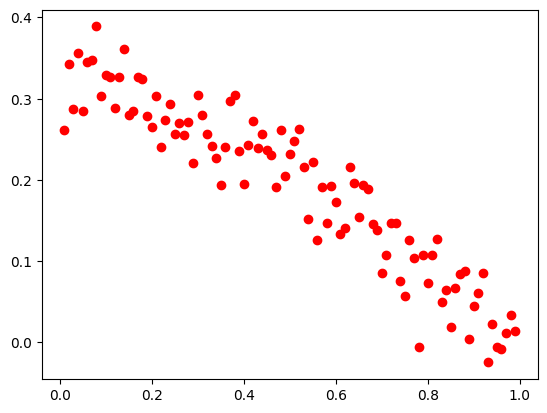

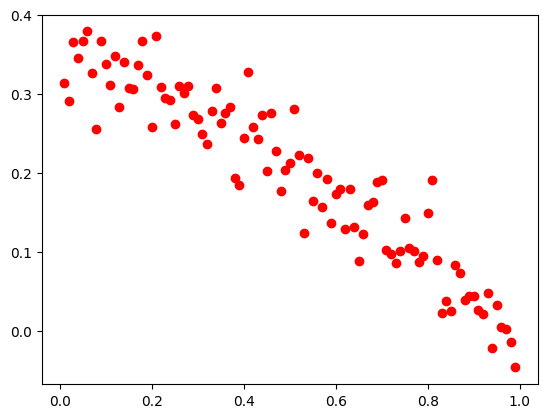

In [20]:
### Generate Data w/ Noise

# If we perform a fit with different pieces of noisey data to generate an uncertainty band \n
# This is known as the replica method (or monte carlo method) for generating uncertainty

N_train = 100
max_sig = max(signal.data)
min_sig = min(signal.data)
noise_amp = 0.1*(max_sig - min_sig)
X_train = []

for i in range(N_train):
  noise = torch.randn_like(signal)*noise_amp
  sample = signal + noise
  X_train.append(sample)

show(X_train[0])
show(X_train[30])

In [5]:
##### DNN Regression

In [21]:
##### Define Model for Collinear Modulation

### NN = NN(x, q_type); q_type is quark type (modulate pdf for each quark type to prouce g_1T)
### For moderate x, restrict to just valence (up and down)

### Need to normalize to N >> But N is a parameter? I guess just choose N = 1

### NN Definition

class MLPcondensed(nn.Module):
    '''
    Multi-layer perceptron for non-linear regression.
    '''
    def __init__(self, nInput, nHidden, nOutput):
        super().__init__()
        self.layers = nn.Sequential(
            # Specify layers, followed by activation for that layer
            # What if you want different activations for different nodes?
            # When would that ^ be desireable?
            nn.Linear(nInput, nHidden),
            #nn.Sigmoid(),
            #nn.LeakyReLU(),
            #nn.ReLU(),
            nn.Tanh(),
            #nn.Softplus(),
            nn.Linear(nHidden, nHidden),
            #nn.Sigmoid(),
            #nn.LeakyReLU(),
            #nn.ReLU(),
            nn.Tanh(),
            #nn.Softplus(),
            nn.Linear(nHidden, nHidden),
            #nn.Sigmoid(),
            #nn.LeakyReLU(),
            #nn.ReLU(),
            nn.Tanh(),
            #nn.Softplus(),
            nn.Linear(nHidden, nOutput)
        )

    def forward(self, x):
        return(self.layers(x))

    # def forward(self, zL, zh, hadron, lambda_bar):
    #     return(self.layers(zL, zh, hadron, lambda_bar))

### 2 input x, q_type
mlpCondensed = MLPcondensed(1,3,1)
DNN_model_1 = mlpCondensed

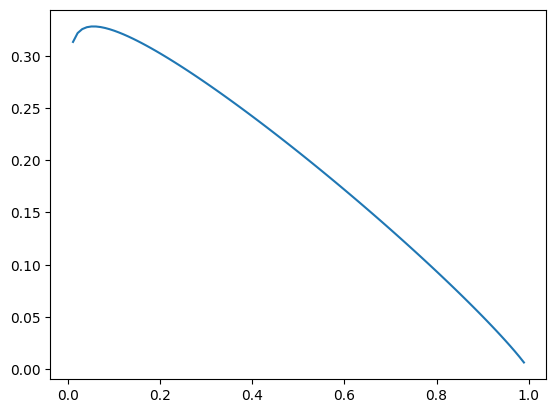

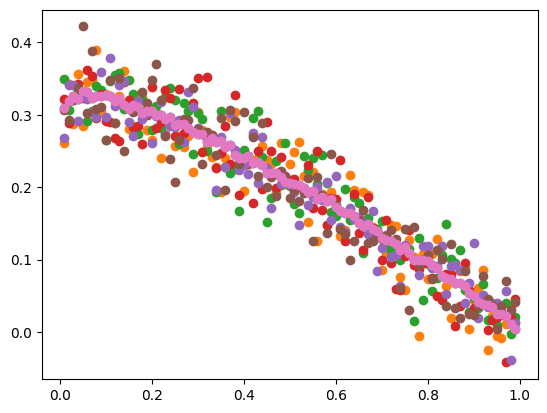

In [22]:
### Plot Central Values

# Just to see how the average data (the true function, if you like) compares across the entire set

plt.figure(0)
plt.plot(x.data, h(x, sig_params).data)


### Plot scattered central values

plt.figure(1)

avg_rep = torch.zeros(len(x))

for n in range(N_train):

    avg_rep += X_train[n]

avg_rep /= N_train

plt.scatter(x.data, avg_rep.data)
for i in range(5): plt.scatter(x.data, X_train[i].data)

plt.scatter(x.data, avg_rep.data)

In [8]:
# This is necessary for DNN_model_1 to serve as an input to our model

x_input = torch.reshape(x, (len(x), 1))

# Ex:
DNN_model_1(x_input).squeeze()

tensor([0.1359, 0.1359, 0.1359, 0.1359, 0.1359, 0.1359, 0.1360, 0.1360, 0.1360,
        0.1360, 0.1360, 0.1361, 0.1361, 0.1361, 0.1361, 0.1361, 0.1362, 0.1362,
        0.1362, 0.1363, 0.1363, 0.1363, 0.1363, 0.1364, 0.1364, 0.1365, 0.1365,
        0.1365, 0.1366, 0.1366, 0.1367, 0.1367, 0.1368, 0.1368, 0.1369, 0.1369,
        0.1370, 0.1371, 0.1371, 0.1372, 0.1373, 0.1374, 0.1374, 0.1375, 0.1376,
        0.1377, 0.1378, 0.1379, 0.1380, 0.1381, 0.1382, 0.1383, 0.1384, 0.1386,
        0.1387, 0.1388, 0.1390, 0.1391, 0.1393, 0.1394, 0.1396, 0.1398, 0.1399,
        0.1401, 0.1403, 0.1405, 0.1407, 0.1409, 0.1411, 0.1413, 0.1415, 0.1418,
        0.1420, 0.1422, 0.1425, 0.1427, 0.1430, 0.1433, 0.1435, 0.1438, 0.1441,
        0.1444, 0.1447, 0.1450, 0.1453, 0.1456, 0.1459, 0.1462, 0.1465, 0.1468,
        0.1471, 0.1475, 0.1478, 0.1481, 0.1484, 0.1487, 0.1490, 0.1493, 0.1496,
        0.1499], grad_fn=<SqueezeBackward0>)

In [9]:
### Organize data into batches
xObs = x
yObs = X_train[0]

for i in range(1, len(X_train)):

    xObs = torch.cat((xObs, x))
    yObs = torch.cat((yObs, X_train[i]))

In [10]:
### Organize Training Data

### They want to use Dataloaders in batches of 25 training points
### Apparently networks learn better this way

class nonLinearRegressionData(Dataset): #Dataset comes with some nice methods
    '''
    Custom 'Dataset' object for our regression data.
    Must implement these functions: __init__, __len__, and __getitem__.
    '''

    def __init__(self, xObs, yObs):

        # Reshape I think because need them to be matrices for network input
        self.xObs = torch.reshape(xObs, (len(xObs), 1))
        self.yObs = torch.reshape(yObs, (len(yObs), 1))

    def __len__(self):
        return(len(self.xObs))

    def __getitem__(self, idx):
        return(xObs[idx], yObs[idx])

# instantiate Dataset object for current training data
d = nonLinearRegressionData(xObs, yObs)

print(d)

train_dataloader = DataLoader(d, batch_size=10 , shuffle=True)

In [11]:
### Train
from tqdm import tqdm

# Define the loss function and optimizer
mlpCondensed = MLPcondensed(1,10,1)
DNN_model = mlpCondensed
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(DNN_model.parameters(), lr=1e-2)
nTrainSteps = 30
#nTrainSteps = 60
initial_params = []

def training(a):
  torch.manual_seed(a)
  mlpCondensed = MLPcondensed(1,10,1)
  DNN_model_test = mlpCondensed
  #optimizer_2 = torch.optim.Adam(DNN_model_test.parameters(), lr=1e-2)
  optimizer_2 = torch.optim.SGD(DNN_model_test.parameters(), lr=1e-2, momentum=0.9)
  initial_params.append(list(DNN_model_test.parameters()))
  # Track loss over epochs
  track_loss = np.zeros(nTrainSteps)
  track_loss2 = np.zeros(nTrainSteps)
  input_indx = -1
  #saved_data = 0 #for whatever training data was used
  # Run the training loop
  for epoch in tqdm(range(0, nTrainSteps)):
    # Iterate over the DataLoader for training data
    for i, data in enumerate(train_dataloader, 0):

      # Get inputs
      inputs, targets = data
      # Zero the gradients
      optimizer_2.zero_grad()

      while input_indx < len(inputs) and inputs[input_indx] < 0.1:
        input_indx += 1

      if input_indx != -1:
        input_indx +=1 #to counter the fact that initial value of input_indx was -1
      
      # Perform forward pass (make sure to supply the input in the right way)
      outputs = DNN_model_test(torch.reshape(inputs, (len(inputs), 1))).squeeze()
      if input_indx != -1:
        outputs2 = DNN_model_test(torch.reshape(inputs[:input_indx], (len(inputs[:input_indx]), 1))).squeeze()

      #saved_data = inputs
      # Compute loss
      loss = loss_function(outputs, targets)

      if input_indx != -1:
        loss2 = loss_function(outputs2, targets[:input_indx])

      # Perform backward pass
      loss.backward(retain_graph = True)
      
      if input_indx != -1:
        loss2.backward(retain_graph = True)

      # Perform optimization
      optimizer_2.step()

      track_loss[epoch] = loss.item()
      if input_indx != -1:
        track_loss2[epoch] = loss2.item()

  #Changing so we're getting output from testing the model
  tested_output = DNN_model_test(x_input).squeeze().data
  #return track_loss, tested_output, a, list(DNN_model_test.parameters())# outputs, saved_data
  return track_loss, tested_output, a, track_loss2

# Process is complete.
#print('Training process has finished.')

In [12]:
import threading
#import concurrent.futures

  0%|          | 0/30 [00:00<?, ?it/s]/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
  0%|          | 0/30 [00:00<?, ?it/s]/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
  0%|          | 0/30 [00:00<?, ?it/s]/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect r

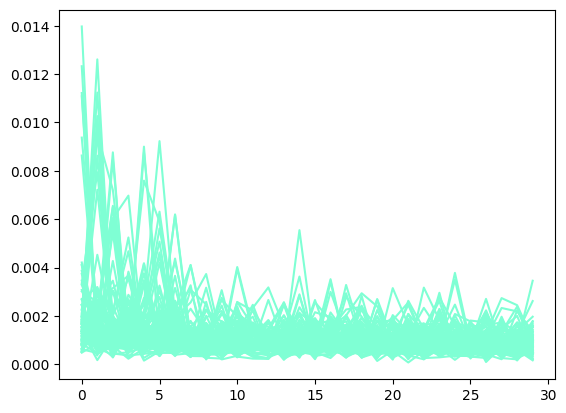

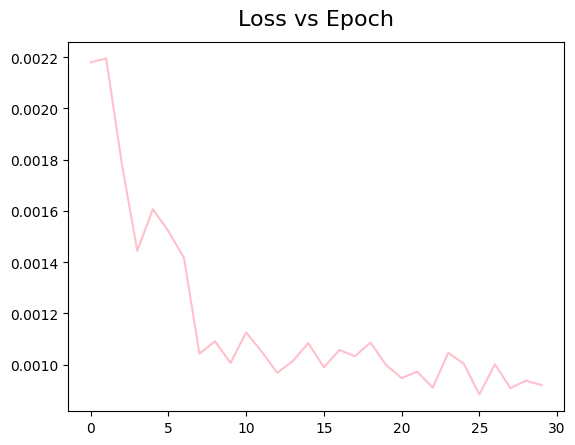

In [13]:
done_losses = {} #dictionary
gotten_results = {}
outputs = []
saved_params = []
numIters = 100
saved_losses = {}
from concurrent.futures import ProcessPoolExecutor as Executor
saved_thread_nums = []
with Executor() as executor:
  for i in range(0,numIters):
    thread_num = "t" + str(i)
    thread_num = executor.submit(training, i)
    saved_thread_nums.append(thread_num)
  
  for i in range(0,numIters):
    #results_of_iteration, outputs, test, initial_params_one = saved_thread_nums[i].result()
    results_of_iteration, outputs, test, new_losses = saved_thread_nums[i].result()
    saved_losses[i] = new_losses
    #print(new_losses)
    #initial_params.append(inital_params_one)
    plt.plot(np.arange(nTrainSteps), results_of_iteration, color = "aquamarine")
    #print(saved_params)
    #print(test)
    #results_of_iteration, outputs, data_trained = training() #gets current array
    #results_of_iteration, outputs, one_sample, data_trained = training() #gets current array
    #print(results_of_iteration)
    for j in range(0,nTrainSteps):
      if j in done_losses:
        done_losses[j] += results_of_iteration[j]
      else:
        done_losses[j] = results_of_iteration[j]
    #gotten_results[i] = DNN_model(x_input).squeeze().data
    gotten_results[i] = outputs

average_losses = [0]*nTrainSteps
for i in range(0,nTrainSteps):
  average_losses[i] = done_losses[i]/numIters

avg_results = [0]*len(gotten_results[0])
for i in range(0,numIters):
  for j in range(0,len(gotten_results[i])):
      avg_results[j] += gotten_results[i][j]
  #print(avg_results)
for i in range(0,len(avg_results)):
  avg_results[i] /= numIters

# print("average losses ", average_losses)
plt.figure(0)
plt.title("Loss vs Epoch", fontsize = 16, pad = 12)
plt.plot(np.arange(nTrainSteps), average_losses, color = "pink")
#plt.plot(np.arange(nTrainSteps), results_of_iteration, label = "Last iteration", color = "blue")


In [14]:
#for i in range(0,len(initial_params)):
 #   print(initial_params[i])
#print(len(initial_params))
#print(initial_params[1])
#print("space")
#print(initial_params[2])

for i in range(0, numIters):
    newlist = saved_losses[i]
    print("NEW LOOP:")
    for i in range(0, len(newlist)):
        print(newlist)

NEW LOOP:
[0.00155362 0.0012435  0.00089795 0.0005868  0.00876359 0.00212725
 0.0023413  0.00311223 0.00077378 0.00306406 0.00052859 0.00054104
 0.00079377 0.00245845 0.00068404 0.00059216 0.00067736 0.00076979
 0.00079725 0.00024574 0.00105131 0.00085949 0.00112626 0.00065512
 0.00163844 0.00141608 0.00107409 0.00038662 0.00119521 0.00048326]
[0.00155362 0.0012435  0.00089795 0.0005868  0.00876359 0.00212725
 0.0023413  0.00311223 0.00077378 0.00306406 0.00052859 0.00054104
 0.00079377 0.00245845 0.00068404 0.00059216 0.00067736 0.00076979
 0.00079725 0.00024574 0.00105131 0.00085949 0.00112626 0.00065512
 0.00163844 0.00141608 0.00107409 0.00038662 0.00119521 0.00048326]
[0.00155362 0.0012435  0.00089795 0.0005868  0.00876359 0.00212725
 0.0023413  0.00311223 0.00077378 0.00306406 0.00052859 0.00054104
 0.00079377 0.00245845 0.00068404 0.00059216 0.00067736 0.00076979
 0.00079725 0.00024574 0.00105131 0.00085949 0.00112626 0.00065512
 0.00163844 0.00141608 0.00107409 0.00038662 0.001

test
100
<class 'list'>
[0.002179446641530376, 0.0021945975995913613, 0.001786099029122852, 0.001444467538385652, 0.0016067938297055662, 0.0015215219534002245, 0.001416967484401539, 0.001043381120543927, 0.001091444500198122, 0.0010073902890144382, 0.0011265024953172542, 0.0010513588010508102, 0.0009689150040503591, 0.0010143974883249029, 0.0010842463976587168, 0.000990405053307768, 0.0010576048580696806, 0.0010332376978476531, 0.0010868088822462596, 0.0009989044509711676, 0.0009481268613308202, 0.0009730893297091825, 0.0009107352641876787, 0.0010466727838502265, 0.001003913353488315, 0.0008841754769673571, 0.0010020809900743188, 0.0009089383159880526, 0.0009381737114745192, 0.0009206238509796094]
<class 'torch.Tensor'>
<class 'torch.Tensor'>


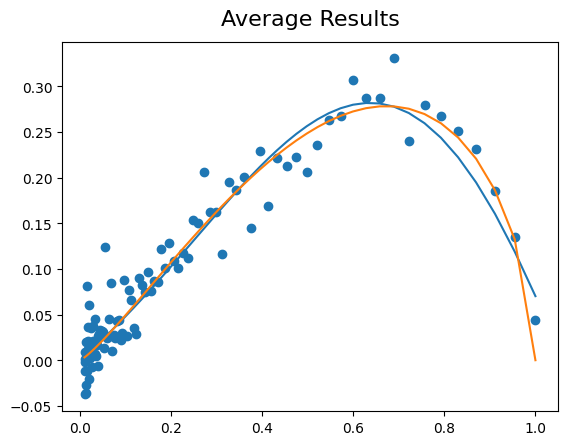

In [18]:
### I find it useful to plot how the loss evolves during training
print("test")
print(len(avg_results))
print(type(avg_results))
#print(len(data_trained))
#print(type(data_trained.detach().numpy()))
print(average_losses)
print(type(x.data))
print(type(h(x, sig_params).data))
plt.title("Average Results", fontsize = 16, pad = 12)
plt.plot(x.data, avg_results, label = 'Average Fit')
#plt.plot(data_trained, avg_results, label = 'Average Fit')
plt.plot(x.data, h(x, sig_params).data, label = 'True PDF')
plt.scatter(x.data, X_train[0].data)
# This can tell you if we plateau rapidly, etc

#plt.figure(0)
#plt.title("Loss vs Epoch", fontsize = 16, pad = 12)
#plt.plot(np.arange(nTrainSteps), track_loss)

In [16]:
### Plot model results, true signal, and noisey data point

'''avg_tensor = torch.tensor(one_sample, dtype=torch.float32)
sorted_tensor = avg_tensor.sort()[0]
#print(type(x.data))
plt.title("One Sample", fontsize = 16, pad = 12)
#FOR LOOP TO .detach().numpy() each value in avg_results???
new_list = [0]*len(avg_results)
for i in range(0,len(new_list)):
  new_list[i] = avg_results[i].detach()
print("test")
print(new_list)
dict_vals = {}
for i in range(0,len(avg_tensor)):
  dict_vals[data_trained[i]] = avg_tensor[i]
sorted_dict_keys = sorted(dict_vals.keys())
sorted_dict = {key: dict_vals[key] for key in sorted_dict_keys}
print(sorted_dict)
new_tensor_list = [0]*len(dict_vals)
new_values_list = [0]*len(dict_vals)
i = 0
for key in sorted_dict:
  new_values_list[i] = key
  new_tensor_list[i] = sorted_dict[key]
  i += 1
print("hi")
print(new_tensor_list)
plt.plot(new_values_list, new_tensor_list, label = 'Average Fit')
plt.plot(x.data, h(x, sig_params).data, label = 'True PDF')
plt.scatter(x.data, X_train[0].data)'''

'avg_tensor = torch.tensor(one_sample, dtype=torch.float32)\nsorted_tensor = avg_tensor.sort()[0]\n#print(type(x.data))\nplt.title("One Sample", fontsize = 16, pad = 12)\n#FOR LOOP TO .detach().numpy() each value in avg_results???\nnew_list = [0]*len(avg_results)\nfor i in range(0,len(new_list)):\n  new_list[i] = avg_results[i].detach()\nprint("test")\nprint(new_list)\ndict_vals = {}\nfor i in range(0,len(avg_tensor)):\n  dict_vals[data_trained[i]] = avg_tensor[i]\nsorted_dict_keys = sorted(dict_vals.keys())\nsorted_dict = {key: dict_vals[key] for key in sorted_dict_keys}\nprint(sorted_dict)\nnew_tensor_list = [0]*len(dict_vals)\nnew_values_list = [0]*len(dict_vals)\ni = 0\nfor key in sorted_dict:\n  new_values_list[i] = key\n  new_tensor_list[i] = sorted_dict[key]\n  i += 1\nprint("hi")\nprint(new_tensor_list)\nplt.plot(new_values_list, new_tensor_list, label = \'Average Fit\')\nplt.plot(x.data, h(x, sig_params).data, label = \'True PDF\')\nplt.scatter(x.data, X_train[0].data)'

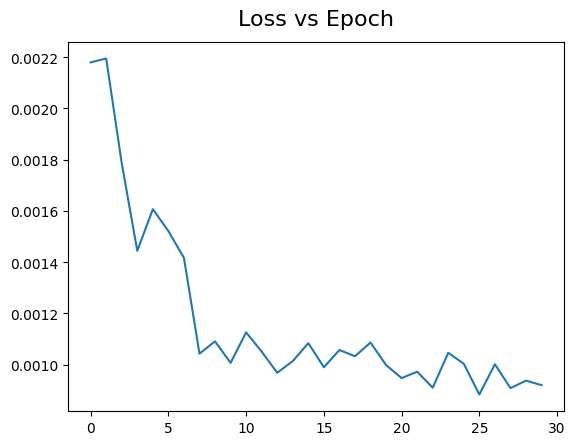

In [17]:
plt.title("Loss vs Epoch", fontsize = 16, pad = 12)
plt.plot(np.arange(nTrainSteps), average_losses)